# Classifiez automatiquement des biens de consommation
# Classification supervisée

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

# Imports

In [2]:
import sys
import time
import os
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn import metrics, preprocessing, manifold
from sklearn.model_selection import train_test_split

import shutil
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [3]:
file_path = 'data_cleaned.csv'
df = pd.read_csv(file_path)
df.shape

(1050, 10)

In [4]:
train_size = 0.75
val_size = 0.25
test_size = 0.25

batch_size = 64

# Prétraitement

In [5]:
df.head(3)

,uniq_id,product_name,product_category_tree,image,description,cat1,sentence_bow_lem,sentence_bow,sentence_dl,img_path
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key feature elegance polyester multicolor abst...,key features elegance polyester multicolor abs...,key features of elegance polyester multicolor ...,C:\Users\octav\Documents\Formation Data Scient...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specification sathiyas cotton bath towel bath ...,specifications sathiyas cotton bath towel bath...,specifications of sathiyas cotton bath towel 3...,C:\Users\octav\Documents\Formation Data Scient...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key feature eurospa cotton terry face towel se...,key features eurospa cotton terry face towel s...,key features of eurospa cotton terry face towe...,C:\Users\octav\Documents\Formation Data Scient...


In [6]:
data_to_drop = ['product_name',
                'product_category_tree',
                'description',
                'sentence_bow_lem',
                'sentence_bow',
                'sentence_dl']
df.drop(columns=data_to_drop, inplace=True)

df.head()

,uniq_id,image,cat1,img_path
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,C:\Users\octav\Documents\Formation Data Scient...
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,C:\Users\octav\Documents\Formation Data Scient...
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,C:\Users\octav\Documents\Formation Data Scient...
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,C:\Users\octav\Documents\Formation Data Scient...
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,C:\Users\octav\Documents\Formation Data Scient...


In [7]:
def train_test_folders(df, test_size=0.25):

    # Créer les dossiers train, et test si non présent
    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)

    # Obtenir les classes uniques du dataframe
    classes = df['cat1'].unique()

    # Parcourir chaque classe
    for class_name in classes:

        os.makedirs(os.path.join('train',
                                 class_name), exist_ok=True)
        os.makedirs(os.path.join('test',
                                 class_name), exist_ok=True)
        # Filtrer les images de la classe spécifique
        class_images = df[df['cat1'] == class_name]

        # Diviser les images en ensembles de train, validation et test
        train_images, test_images = train_test_split(
            class_images,
            test_size=test_size,
            random_state=42)

        # Déplacer les images dans les dossiers correspondants
        for _, image_row in train_images.iterrows():
            shutil.copy(image_row['img_path'],
                        os.path.join('train',
                                     class_name,
                                     image_row['image']))
        for _, image_row in test_images.iterrows():
            shutil.copy(image_row['img_path'],
                        os.path.join('test',
                                     class_name,
                                     image_row['image']))

In [8]:
train_test_folders(df, test_size)

In [9]:
df["cat1"].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [10]:
path = "train/"
path_test = "test/"

list_labels = df["cat1"].unique()
label_no_name = "no_name "


def photo_class(photo):
    for label in list_labels:
        if label in photo[:40]:
            return label
    return label_no_name


data_path = glob(path+'*/*.jp*')
data_test_path = glob(path_test+'*/*.jp*')


def data_fct(path):
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x: photo_class(x))
    return data


data = data_fct(data_path)
data_test = data_fct(data_test_path)

le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])

data_test["label"] = le.transform(data_test["label_name"])
data.head()

784
266


,image_path,label_name,label
0,train\Baby Care\057836ecde71565f8ebdd576e41fdc...,Baby Care,0
1,train\Baby Care\0906fd9cc604fbba05a502e01d763c...,Baby Care,0
2,train\Baby Care\093bcad64d11c0aed903a8dd787ef0...,Baby Care,0
3,train\Baby Care\0991e8d8f884003ab1889097119108...,Baby Care,0
4,train\Baby Care\0bff0eda7a6677dc1acb0477a1f7a1...,Baby Care,0


In [11]:
data_test.head()

,image_path,label_name,label
0,test\Baby Care\184ecf07ca4e2872eaf53d2344a1e78...,Baby Care,0
1,test\Baby Care\25ce025c38c55f28fd0ea3bb0200df7...,Baby Care,0
2,test\Baby Care\27b7851ae3dfc2ae8c1958cebe93bf0...,Baby Care,0
3,test\Baby Care\2c8912b849cf73676d025aa99203b6d...,Baby Care,0
4,test\Baby Care\30ab693b54e99a469a1152b5db14aa4...,Baby Care,0


In [12]:
data.groupby('label_name').count()

,image_path,label
label_name,,
Baby Care,112,112
Beauty and Personal Care,112,112
Computers,112,112
Home Decor & Festive Needs,112,112
Home Furnishing,112,112
Kitchen & Dining,112,112
Watches,112,112


In [13]:
data_test.groupby('label_name').count()

,image_path,label
label_name,,
Baby Care,38,38
Beauty and Personal Care,38,38
Computers,38,38
Home Decor & Festive Needs,38,38
Home Furnishing,38,38
Kitchen & Dining,38,38
Watches,38,38


# Classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


In [14]:
# Score df initialisation

scores = pd.DataFrame(columns=['val_accuracy',
                               'val_loss',
                               'test_accuracy',
                               'test_loss',
                               'time'])
scores

,val_accuracy,val_loss,test_accuracy,test_loss,time


## Création du modèle de classification

In [15]:
def create_model_fct():
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False,
                   weights="imagenet",
                   input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy",
                  optimizer='rmsprop',
                  metrics=["accuracy"])

    print(model.summary())

    return model

## Approche préparation initiale des images

In [16]:
def image_prep_fct(data):
    prepared_images = []

    for image_num in range(len(data['image_path'])):
        if image_num % 100 == 0:
            print(image_num)
        img = (load_img(data['image_path'][image_num],
                        target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)

    return prepared_images_np


images_np = image_prep_fct(data)
print(images_np.shape)

images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

0
100
200
300
400
500


C:\Users\octav\anaconda3\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


600
700
(784, 224, 224, 3)
0
100
200
(266, 224, 224, 3)


In [17]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  stratify=y,
                                                  test_size=val_size,
                                                  random_state=42)
X_train.shape

(588, 224, 224, 3)

In [19]:
# Création du modèle
model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
temps1 = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
history1 = model1.fit(X_train, y_train,
                      epochs=50, batch_size=batch_size,
                      callbacks=callbacks_list,
                      validation_data=(X_val, y_val),
                      verbose=1)

duration1 = time.time()-temps1

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 5.8517 - accuracy: 0.4422
Epoch 1: val_loss improved from inf to 2.04326, saving model to .\model1_best_weights.h5
10/10 [==============================] - 63s 6s/step - loss: 5.8517 - accuracy: 0.4422 - val_loss: 2.0433 - val_accuracy: 0.6939
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.2117 - accuracy: 0.6803
Epoch 2: val_loss improved from 2.04326 to 1.84691, saving model to .\model1_best_weights.h5
10/10 [==============================] - 58s 6s/step - loss: 2.2117 - accuracy: 0.6803 - val_loss: 1.8469 - val_accuracy: 0.7347
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.3471 - accuracy: 0.7636
Epoch 3: val_loss improved from 1.84691 to 1.58518, saving model to .\model1_best_weights.h5
10/10 [==============================] - 58s 6s/step - loss: 1.3471 - accuracy: 0.7636 - val_loss: 1.5852 - val_accuracy: 0.7857
Epoch 4/50
10/10 [==============================] - ETA:

In [21]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

19/19 [==============================] - 43s 2s/step - loss: 0.0118 - accuracy: 0.9949
Training Accuracy: 0.9949

7/7 [==============================] - 14s 2s/step - loss: 1.4469 - accuracy: 0.8163
Validation Accuracy:  0.8163


In [22]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

val_loss, val_accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy))

7/7 [==============================] - 14s 2s/step - loss: 1.1540 - accuracy: 0.7908
Validation Accuracy :  0.7908
Test Accuracy       :  0.8045


In [23]:
scores.loc["model1", 'val_accuracy'] = val_accuracy
scores.loc["model1", 'val_loss'] = val_loss
scores.loc["model1", 'test_accuracy'] = test_accuracy
scores.loc["model1", 'test_loss'] = test_loss
scores.loc["model1", 'time'] = duration1

In [24]:
scores

,val_accuracy,val_loss,test_accuracy,test_loss,time
model1,0.790816,1.154027,0.804511,1.005492,930.35524


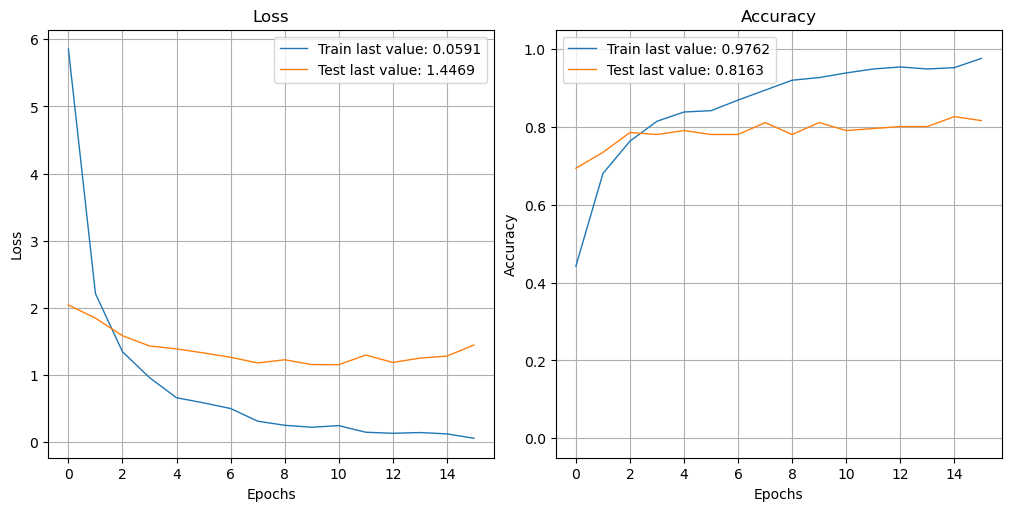

In [25]:
from plot_keras_history import show_history, plot_history

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [26]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 15s 2s/step
[2 3 4 5 4 6 0 0 1 4 3 2 6 4 3 1 0 3 2 6 5 4 0 0 1 6 6 4 1 6 1 6 0 5 1 1 0
 3 4 6 0 5 1 4 3 5 2 1 4 4 2 3 1 4 2 5 4 0 2 0 1 1 4 6 6 3 1 2 0 3 0 0 0 5
 5 2 2 2 1 0 5 5 3 3 4 0 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 4 2 6 5 2 1 3
 3 2 6 3 1 2 3 3 4 3 3 1 2 4 5 2 6 6 2 4 6 3 2 6 6 5 0 6 0 4 1 3 1 2 0 6 4
 4 4 1 5 0 4 4 0 5 5 3 6 6 0 3 3 2 5 0 6 5 3 4 2 6 0 4 1 3 4 1 5 5 5 4 1 1
 3 5 3 5 5 0 2 1 0 5 6]

[2 3 4 5 0 6 0 0 1 4 3 2 6 0 5 1 0 3 2 6 5 4 3 0 1 6 6 4 1 6 1 2 1 5 0 3 0
 4 0 6 0 5 1 4 2 5 2 1 4 4 6 3 1 4 2 5 3 0 2 4 2 1 4 6 6 3 1 2 0 3 0 0 0 5
 5 2 2 2 1 0 5 5 3 0 4 1 5 0 3 6 0 2 6 6 2 1 1 2 0 5 5 6 1 5 4 2 6 5 3 6 3
 3 1 6 3 4 2 3 3 4 3 6 1 2 0 5 2 6 6 2 4 6 3 2 6 6 5 0 6 0 0 1 3 1 3 0 6 4
 4 4 1 5 0 0 4 5 0 5 3 6 6 3 3 3 0 5 0 6 5 3 4 2 6 0 0 2 3 0 1 5 5 5 4 2 1
 3 2 4 5 5 0 2 1 0 5 6]


In [27]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [28]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[22  2  0  2  1  1  0]
 [ 2 20  3  1  1  0  1]
 [ 1  2 20  3  0  1  1]
 [ 1  0  2 21  2  1  1]
 [ 8  0  0  1 19  0  0]
 [ 1  0  1  0  0 26  0]
 [ 0  0  1  0  0  0 27]]

              precision    recall  f1-score   support

           0       0.63      0.79      0.70        28
           1       0.83      0.71      0.77        28
           2       0.74      0.71      0.73        28
           3       0.75      0.75      0.75        28
           4       0.83      0.68      0.75        28
           5       0.90      0.93      0.91        28
           6       0.90      0.96      0.93        28

    accuracy                           0.79       196
   macro avg       0.80      0.79      0.79       196
weighted avg       0.80      0.79      0.79       196



<Axes: >

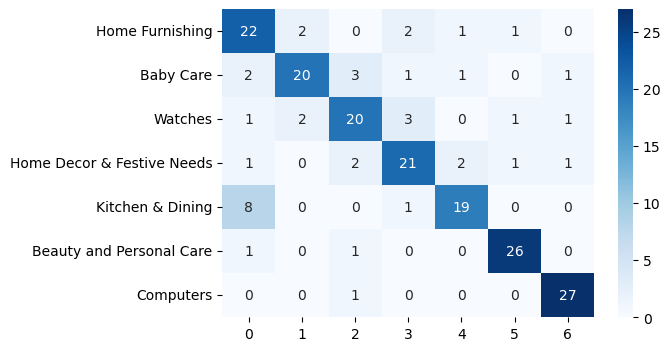

In [29]:
df_cm = pd.DataFrame(conf_mat, index=list_labels,
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
def data_flow_fct(data, datagen, data_type=None):
    data_flow = datagen.flow_from_dataframe(data,
                                            directory='',
                                            x_col='image_path',
                                            y_col='label_name',
                                            weight_col=None,
                                            target_size=(256, 256),
                                            classes=None,
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=42,
                                            subset=data_type)
    return data_flow

In [33]:
datagen_train = ImageDataGenerator(#  featurewise_center=True,
                                   #  featurewise_std_normalization=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=val_size,
                                   preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(validation_split=0,
                                  preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen_train.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 588 validated image filenames belonging to 7 classes.
Found 196 validated image filenames belonging to 7 classes.
Found 266 validated image filenames belonging to 7 classes.


1:36: E261 at least two spaces before inline comment
1:36: E262 inline comment should start with '# '


In [34]:
model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [35]:
temps2 = time.time()

history2 = model2.fit(train_flow,
                      validation_data=val_flow,
                      batch_size=batch_size,
                      epochs=50,
                      callbacks=callbacks_list,
                      verbose=1)

duration2 = time.time()-temps2

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 5.0144 - accuracy: 0.3997

C:\Users\octav\anaconda3\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.92554, saving model to .\model2_best_weights.h5
10/10 [==============================] - 83s 8s/step - loss: 5.0144 - accuracy: 0.3997 - val_loss: 1.9255 - val_accuracy: 0.5663
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.0886 - accuracy: 0.6037
Epoch 2: val_loss improved from 1.92554 to 1.49374, saving model to .\model2_best_weights.h5
10/10 [==============================] - 81s 8s/step - loss: 2.0886 - accuracy: 0.6037 - val_loss: 1.4937 - val_accuracy: 0.6378
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.7041
Epoch 3: val_loss improved from 1.49374 to 1.32382, saving model to .\model2_best_weights.h5
10/10 [==============================] - 81s 8s/step - loss: 1.3383 - accuracy: 0.7041 - val_loss: 1.3238 - val_accuracy: 0.6582
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.7415
Epoch 4: val_loss improved from 1.32382 to 1.21996, sav

In [36]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 60s 6s/step - loss: 0.0944 - accuracy: 0.9643
Training Accuracy   : 0.9643

4/4 [==============================] - 21s 4s/step - loss: 0.9825 - accuracy: 0.7704
Validation Accuracy :  0.7704


In [37]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

val_loss, val_accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy))
print("Validation Loss :  {:.4f}".format(val_loss))

test_loss, test_accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("Test Loss       :  {:.4f}".format(test_loss))

Validation Accuracy :  0.7398
Validation Loss :  1.0845
Test Accuracy       :  0.7632
Test Loss       :  0.9853


In [38]:
scores.loc["model2", 'val_accuracy'] = val_accuracy
scores.loc["model2", 'val_loss'] = val_loss
scores.loc["model2", 'test_accuracy'] = test_accuracy
scores.loc["model2", 'test_loss'] = test_loss
scores.loc["model2", 'time'] = duration2

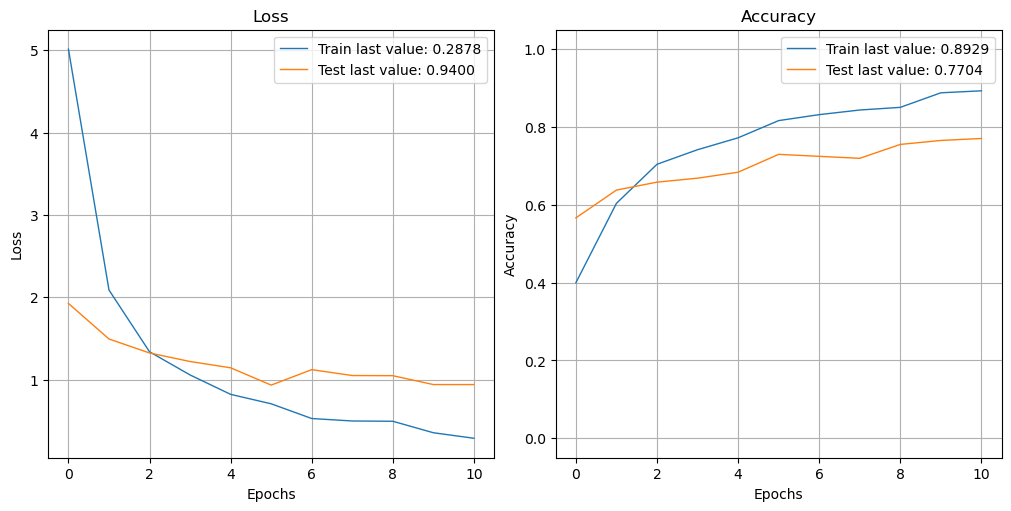

In [39]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [40]:
def dataset_fct(path, validation_split=0, data_type=None):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels='inferred', label_mode='categorical',
        class_names=None, batch_size=batch_size,
        image_size=(224, 224), shuffle=True,
        seed=42, validation_split=validation_split,
        subset=data_type)
    return dataset

In [41]:
dataset_train = dataset_fct(path,
                            validation_split=val_size,
                            data_type='training')
dataset_val = dataset_fct(path,
                          validation_split=val_size,
                          data_type='validation')
dataset_test = dataset_fct(path_test,
                           validation_split=0,
                           data_type=None)

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (82 > 79 characters)


Found 784 files belonging to 7 classes.
Using 588 files for training.
Found 784 files belonging to 7 classes.
Using 196 files for validation.
Found 266 files belonging to 7 classes.


In [42]:
# Création du modèle
model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [43]:
temps3 = time.time()

history3 = model3.fit(dataset_train,
                      validation_data=dataset_val,
                      batch_size=batch_size,
                      epochs=50,
                      callbacks=callbacks_list,
                      verbose=1)

duration3 = time.time()-temps3

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 7.2344 - accuracy: 0.4371
Epoch 1: val_loss improved from inf to 1.85400, saving model to .\model3_best_weights.h5
10/10 [==============================] - 60s 6s/step - loss: 7.2344 - accuracy: 0.4371 - val_loss: 1.8540 - val_accuracy: 0.7602
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.9030 - accuracy: 0.6684
Epoch 2: val_loss improved from 1.85400 to 1.57180, saving model to .\model3_best_weights.h5
10/10 [==============================] - 60s 6s/step - loss: 2.9030 - accuracy: 0.6684 - val_loss: 1.5718 - val_accuracy: 0.7551
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 2.0346 - accuracy: 0.7279
Epoch 3: val_loss improved from 1.57180 to 1.46158, saving model to .\model3_best_weights.h5
10/10 [==============================] - 60s 6s/step - loss: 2.0346 - accuracy: 0.7279 - val_loss: 1.4616 - val_accuracy: 0.7551
Epoch 4/50
10/10 [==============================] - ETA:

In [44]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 45s 4s/step - loss: 0.0216 - accuracy: 0.9915
Training Accuracy   : 0.9915

4/4 [==============================] - 15s 3s/step - loss: 1.2310 - accuracy: 0.7908
Validation Accuracy :  0.7908


In [45]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

val_loss, val_accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

test_loss, test_accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy))

Validation Accuracy :  0.7959
Test Accuracy       :  0.8120


In [46]:
scores.loc["model3", 'val_accuracy'] = val_accuracy
scores.loc["model3", 'val_loss'] = val_loss
scores.loc["model3", 'test_accuracy'] = test_accuracy
scores.loc["model3", 'test_loss'] = test_loss
scores.loc["model3", 'time'] = duration3

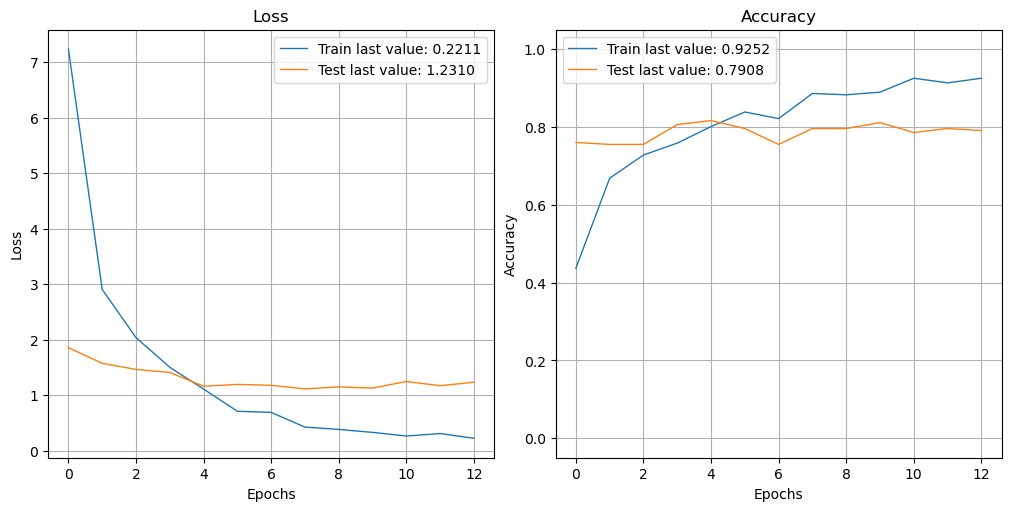

In [47]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [48]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model3.predict(X_test), axis=1)
y_test_num = np.argmax(y_test, axis=1)
print(y_test_num)
print()
print(y_test_pred)

9/9 [==============================] - 20s 2s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6]

[5 0 3 0 0 0 1 0 3 0 0 0 0 0 0 0 0 3 0 0 0 4 0 0 0 0 0 0 4 5 0 0 0 4 4 3 3
 0 2 3 1 1 2 1 1 1 1 1 6 1 1 1 1 1 2 1 1 1 5 1 1 1 3 1 1 1 2 1 0 1 1 0 1 1
 1 1 4 2 2 2 2 5 2 2 2 2 2 2 2 2 2 3 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 4 3 3 3 5 3 4 3 6 3 3 3 3 5
 3 0 2 3 3 4 4 0 0 4 4 4 4 0 4 0 4 0 4 4 4 4 4 4 4 0 4 4 1 4 4 4 4 4 3 4 4
 4 4 4 4 4 5 3 5 3 5 5 5 5 5 2 5

In [49]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [50]:
y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[26  1  0  5  4  2  0]
 [ 2 28  4  2  0  1  1]
 [ 1  1 33  1  1  1  0]
 [ 1  0  1 29  2  4  1]
 [ 6  1  0  2 29  0  0]
 [ 1  0  3  2  0 32  0]
 [ 0  1  1  1  0  0 35]]

              precision    recall  f1-score   support

           0       0.70      0.68      0.69        38
           1       0.88      0.74      0.80        38
           2       0.79      0.87      0.82        38
           3       0.69      0.76      0.72        38
           4       0.81      0.76      0.78        38
           5       0.80      0.84      0.82        38
           6       0.95      0.92      0.93        38

    accuracy                           0.80       266
   macro avg       0.80      0.80      0.80       266
weighted avg       0.80      0.80      0.80       266



<Axes: >

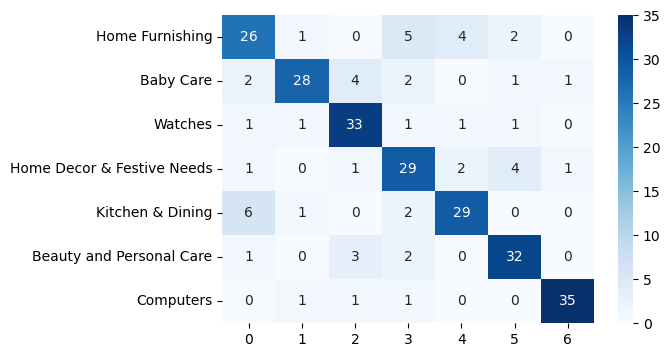

In [51]:
df_cm = pd.DataFrame(conf_mat, index=list_labels,
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [52]:
def dataset_fct(path, validation_split=0, data_type=None):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels='inferred', label_mode='categorical',
        class_names=None, batch_size=batch_size,
        image_size=(224, 224), shuffle=True, seed=42,
        validation_split=validation_split, subset=data_type)
    return dataset

In [53]:
dataset_train = dataset_fct(path, validation_split=val_size, data_type='training')
dataset_val = dataset_fct(path, validation_split=val_size, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (82 > 79 characters)


Found 784 files belonging to 7 classes.
Using 588 files for training.
Found 784 files belonging to 7 classes.
Using 196 files for validation.
Found 266 files belonging to 7 classes.


In [54]:
def create_model_fct2():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
    ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False,
                       weights="imagenet",
                       input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([data_augmentation,
                        Rescaling(1./127.5, offset=-1),
                        model_base,
                        GlobalAveragePooling2D(),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(7, activation='softmax')])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])

    print(model.summary())

    return model

In [55]:
# Création du modèle
model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [56]:
temps4 = time.time()

history4 = model4.fit(dataset_train,
                      validation_data=dataset_val,
                      batch_size=batch_size,
                      epochs=50,
                      callbacks=callbacks_list,
                      verbose=1)

duration4 = time.time()-temps4

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.9572 - accuracy: 0.2092
Epoch 1: val_loss improved from inf to 1.59073, saving model to .\model4_best_weights.h5
10/10 [==============================] - 64s 6s/step - loss: 1.9572 - accuracy: 0.2092 - val_loss: 1.5907 - val_accuracy: 0.5663
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.6133 - accuracy: 0.4286
Epoch 2: val_loss improved from 1.59073 to 1.32896, saving model to .\model4_best_weights.h5
10/10 [==============================] - 62s 6s/step - loss: 1.6133 - accuracy: 0.4286 - val_loss: 1.3290 - val_accuracy: 0.7245
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.4063 - accuracy: 0.5306
Epoch 3: val_loss improved from 1.32896 to 1.14887, saving model to .\model4_best_weights.h5
10/10 [==============================] - 62s 6s/step - loss: 1.4063 - accuracy: 0.5306 - val_loss: 1.1489 - val_accuracy: 0.6990
Epoch 4/50
10/10 [==============================] - ETA:

10/10 [==============================] - 60s 6s/step - loss: 0.6540 - accuracy: 0.7959 - val_loss: 0.6878 - val_accuracy: 0.7857
Epoch 20/50
10/10 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.7823
Epoch 20: val_loss improved from 0.68024 to 0.66279, saving model to .\model4_best_weights.h5
10/10 [==============================] - 60s 6s/step - loss: 0.6840 - accuracy: 0.7823 - val_loss: 0.6628 - val_accuracy: 0.7908
Epoch 21/50
10/10 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.8010
Epoch 21: val_loss improved from 0.66279 to 0.65814, saving model to .\model4_best_weights.h5
10/10 [==============================] - 60s 6s/step - loss: 0.6420 - accuracy: 0.8010 - val_loss: 0.6581 - val_accuracy: 0.7857
Epoch 22/50
10/10 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.8010
Epoch 22: val_loss did not improve from 0.65814
10/10 [==============================] - 60s 6s/step - loss: 0.6526 - accuracy: 0.8010 - val

In [57]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 45s 4s/step - loss: 0.3603 - accuracy: 0.8912
Training Accuracy   : 0.8912

4/4 [==============================] - 15s 3s/step - loss: 0.6636 - accuracy: 0.7857
Validation Accuracy :  0.7857


In [58]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

val_loss, val_accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

test_loss, test_accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy))

Validation Accuracy :  0.7908
Test Accuracy       :  0.7519


In [59]:
scores.loc["model4", 'val_accuracy'] = val_accuracy
scores.loc["model4", 'val_loss'] = val_loss
scores.loc["model4", 'test_accuracy'] = test_accuracy
scores.loc["model4", 'test_loss'] = test_loss
scores.loc["model4", 'time'] = duration4

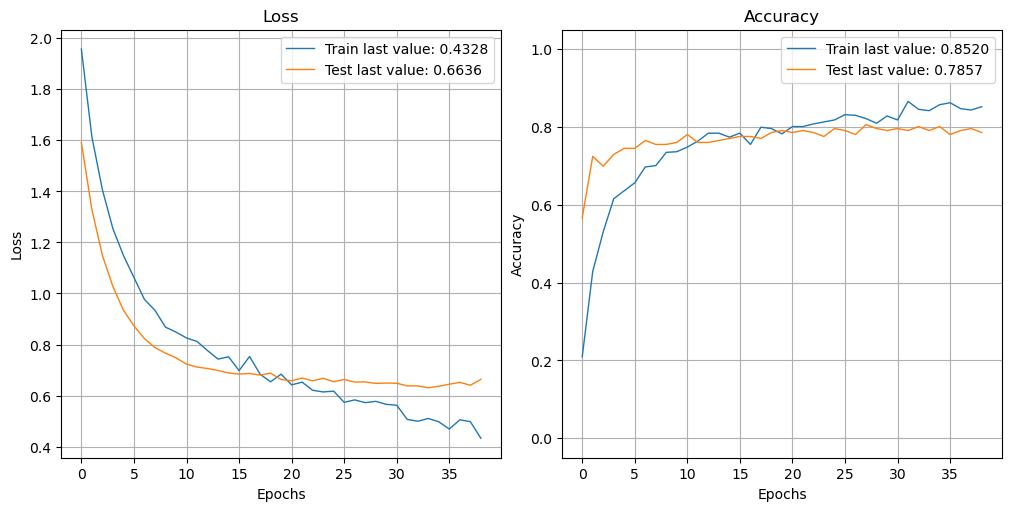

In [60]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# Analyse des scores

In [61]:
scores

,val_accuracy,val_loss,test_accuracy,test_loss,time
model1,0.790816,1.154027,0.804511,1.005492,930.35524
model2,0.739796,1.084526,0.763158,0.985325,905.83058
model3,0.795918,1.111554,0.81203,1.202358,776.880117
model4,0.790816,0.630611,0.75188,0.671281,2389.651839


In [62]:
scores = scores.reindex(columns=["val_accuracy",
                                 "test_accuracy",
                                 "val_loss",
                                 "test_loss",
                                 "time"])

<Axes: >

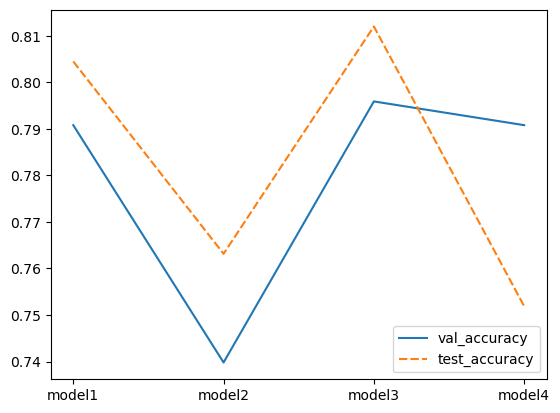

In [63]:
sns.lineplot(scores.iloc[:, :2])

<Axes: >

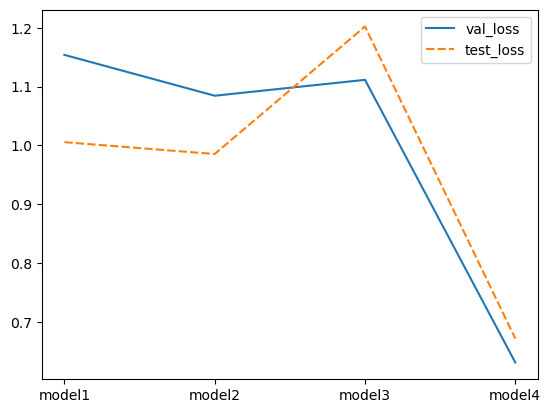

In [64]:
sns.lineplot(scores.iloc[:, -3:-1])

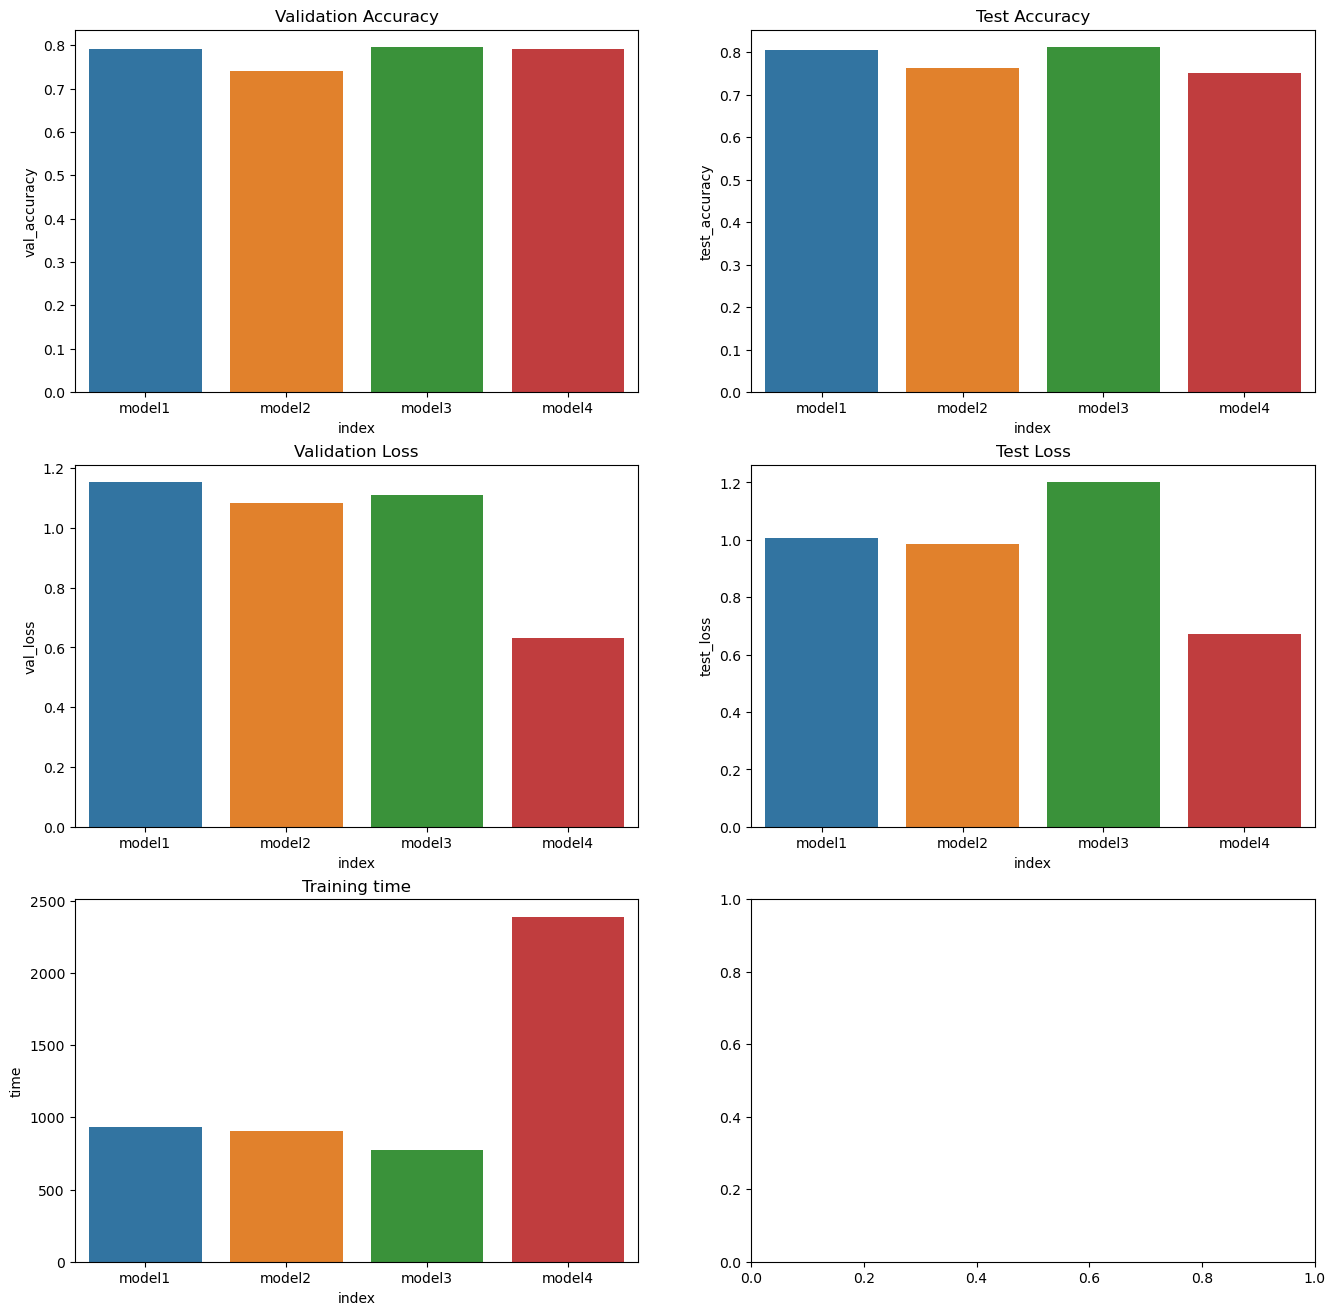

In [65]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))

sns.barplot(scores.reset_index(), y='val_accuracy', x="index", ax=axs[0, 0])
axs[0, 0].title.set_text("Validation Accuracy")
sns.barplot(scores.reset_index(), y='test_accuracy', x="index", ax=axs[0, 1])
axs[0, 1].title.set_text("Test Accuracy")
sns.barplot(scores.reset_index(), y='val_loss', x="index", ax=axs[1, 0])
axs[1, 0].title.set_text("Validation Loss")
sns.barplot(scores.reset_index(), y='test_loss', x="index", ax=axs[1, 1])
axs[1, 1].title.set_text("Test Loss")
sns.barplot(scores.reset_index(), y='time', x="index", ax=axs[2, 0])
axs[2, 0].title.set_text("Training time")

# Conclusion

